## Solve Sudoku - Predicting Missing Digits of Sudoku 

The project objective is to train a deep learning model that can solve a Sudoku puzzle.

In [16]:
import torch
from torch.utils.data import TensorDataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

* Predict the Digits using Task 1 of sudoku and save as csv file
* Convert the csv file to 9,9 npy file which is used for Predicting the Missing digits

In [17]:
unsolved_images_path = r"/kaggle/input/dataset/unsolved.csv"
solved_images_path = r"/kaggle/input/dataset/solved.csv"

unsolved_data = pd.read_csv(unsolved_images_path, sep = ',') 
solved_data = pd.read_csv(solved_images_path, sep = ',') 

In [18]:
def extract_index(data,index_value_name) :
    sudoku_matrix = np.zeros((9,9), dtype = int)
    # Iterate over rows in the DataFrame
    for index ,index_data in data.iterrows():
        _,get_id = index_data['id'].split('_')
        row_index,column_index = int(get_id[0]),int(get_id[1])
        value = int(index_data[index_value_name])
        sudoku_matrix[row_index, column_index] = value
    return sudoku_matrix

In [19]:
#create matrix for train features
start_indexes = 0
unsolved_end_index = len(unsolved_data)
unsolved_matrix_array = []
for index in range (start_indexes,unsolved_end_index,81):
    unsolved_sudoku_matrix = extract_index(unsolved_data[index : index+81],'unsolved')
    unsolved_matrix_array.append(unsolved_sudoku_matrix)


#create matrix for train labels (solution)
solved_end_index = len(solved_data)
solved_matrix_array = []
for index in range (start_indexes,solved_end_index,81):
    solved_sudoku_matrix = extract_index(solved_data[index : index+81],'solved')
    solved_matrix_array.append(solved_sudoku_matrix)

In [20]:
np.save('unsolved_sudoku_matrix.npy', unsolved_matrix_array)
np.save('solved_sudoku_matrix.npy', solved_matrix_array)

### Exploring and visulaizing data

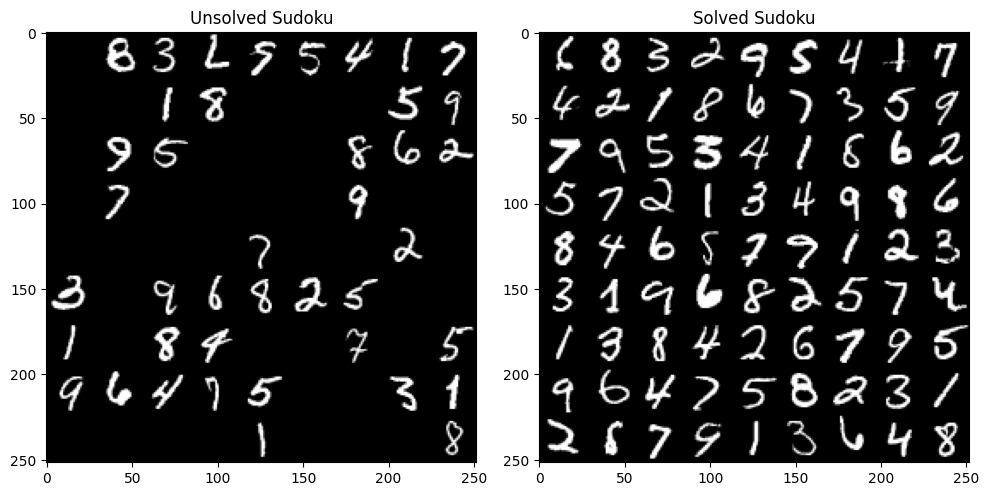

In [21]:
training_images_path = r"/kaggle/input/dataset/training_images.npy"
training_labels_path = r"/kaggle/input/data-for-traintest/training_labels.npy"

training_images = np.load(training_images_path, mmap_mode='r')
training_labels = np.load(training_labels_path, mmap_mode='r') 

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(training_images[0], cmap='gray')
axs[0].set_title('Unsolved Sudoku')

axs[1].imshow(training_labels[0], cmap='gray')
axs[1].set_title('Solved Sudoku')

plt.tight_layout()
plt.show()


In [55]:
train_data = np.load('/kaggle/input/dataset/unsolved_sudoku_matrix.npy')
train_labels = np.load('/kaggle/input/dataset/solved_sudoku_matrix.npy')

In [23]:
train_labels[13].reshape(9,9)

array([[5, 1, 9, 8, 3, 4, 2, 7, 6],
       [8, 3, 2, 7, 5, 6, 1, 4, 9],
       [4, 6, 7, 2, 1, 9, 8, 3, 5],
       [2, 8, 3, 1, 9, 7, 6, 5, 4],
       [7, 9, 1, 4, 6, 5, 3, 2, 8],
       [6, 4, 5, 3, 2, 8, 7, 9, 1],
       [1, 5, 6, 9, 7, 3, 4, 8, 2],
       [3, 7, 4, 5, 8, 1, 9, 6, 7],
       [9, 7, 8, 6, 4, 2, 5, 1, 3]], dtype=int32)

[40 41]
[49932    68]


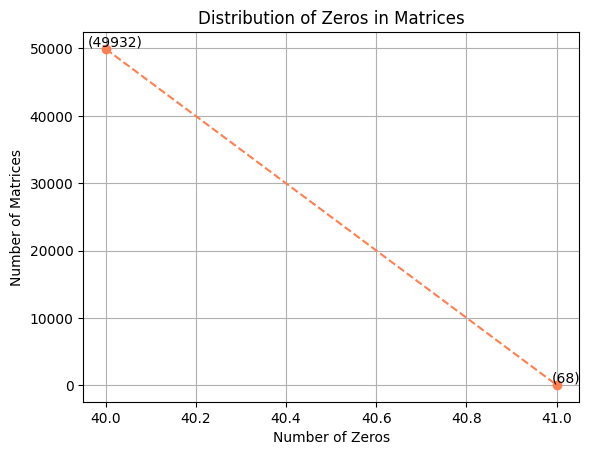

In [24]:
zero_counts = [np.sum(data == 0) for data in train_data]
unique_counts, counts = np.unique(zero_counts, return_counts=True)
print(unique_counts)
print(counts)

plt.plot(unique_counts, counts, marker='o', color='coral', linestyle='--')

for x, y in zip(unique_counts, counts):
    plt.annotate(f'({y})', (x, y), textcoords="offset points", xytext=(7,2), ha='center')

plt.xlabel('Number of Zeros')
plt.ylabel('Number of Matrices')
plt.title('Distribution of Zeros in Matrices')
plt.grid(True)
plt.show()

In [25]:
def is_valid_sudoku(board):
    rows = [set() for _ in range(9)]
    cols = [set() for _ in range(9)]
    subgrids = [set() for _ in range(9)]

    for i in range(9):
        for j in range(9):
            num = board[i][j]
            if num == 0:
                continue

            subgrid_index = (i // 3) * 3 + j // 3

            if num in rows[i] or num in cols[j] or num in subgrids[subgrid_index]:
                return False, (i, j)

            rows[i].add(num)
            cols[j].add(num)
            subgrids[subgrid_index].add(num)

    return True, None

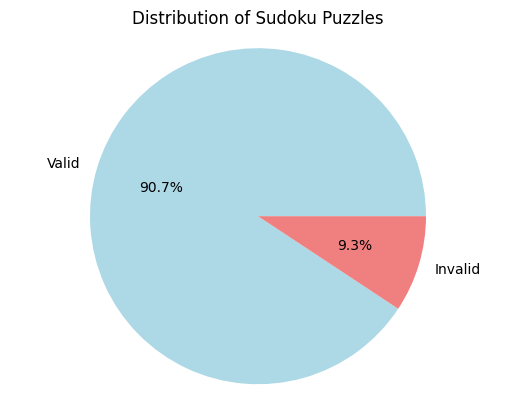

In [26]:
total_sudoku_count = len(train_labels)

# Count the number of invalid sudoku
count_invalid = 0
for index, sudoku in enumerate(train_labels):
    is_valid, sudoku_indices = is_valid_sudoku(sudoku.reshape(9, 9))
    if not is_valid:
        count_invalid += 1

# Calculate the percentage of invalid sudoku
percentage_invalid = (count_invalid / total_sudoku_count) * 100
percentage_valid = 100 - percentage_invalid

labels = ['Valid', 'Invalid']
sizes = [percentage_valid, percentage_invalid]
colors = ['lightblue', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution of Sudoku Puzzles')

plt.show()


In [27]:
# Check if any of the labels contains 0
positions = np.where(train_labels == 0)[0]
if positions.size > 0 : 
    print(f'Image with  index : {positions} have 0s')
    for each_pos in positions : 
        row_pos, col_pos = np.where(train_labels[each_pos] ==0)
        row_values = train_labels[each_pos][row_pos].flatten()
        missing_digit = int(np.setdiff1d(np.arange(1, 10), row_values))
        train_labels[each_pos][row_pos, col_pos] = missing_digit   

Image with  index : [  199   213   468   494   544  1430  1504  1542  1796  2514  3457  4412
  5157  6084  6275  6566  6625  6819  7418  7571  7908  8065  8354  8617
  8672  8998  9040  9360  9723  9887  9890 10278 10321 11129 11174 11452
 11926 12210 12353 12922 13475 13488 13608 14106 14127 14276 14447 14527
 14937 15851 16082 17570 18089 18177 18710 18759 18957 19588 19969 19976
 20242 20267 20362 20796 20844 20962 21133 21424 21536 21795 22199 22536
 22539 22592 23172 23176 23321 23329 23780 25459 25532 26127 26340 26443
 26814 26925 27094 27120 27146 27302 27592 27699 27880 28305 29114 29448
 29627 30178 30271 32552 32778 32795 33383 33563 33618 33717 34187 34837
 34844 35051 35053 35210 35353 35538 35744 36544 36584 36625 36806 36813
 37037 37074 37301 39704 39830 40067 40170 40240 40395 41044 41473 41632
 42876 43323 43555 43703 44005 44297 44413 44447 44750 45147 45409 46175
 46218 46280 46473 46683 46688 47129 47266 47567 48434 49105 49248 49343
 49744 49746 49795] have 0s


### *Approach 1 - (Using MultiLayer Perceptron)*

#### *Data Preprocessing*

In [56]:
def encode_inputs(sudoku_matrix):
    digits = torch.zeros((1, 81, 9), dtype=torch.float)
    for i in range(9):
        for j in range(9):
            digit = sudoku_matrix[i][j]
            if digit > 0:
                digits[0, i*9+j, digit - 1] = 1
    return digits

#### *Creating DataLoaders*

1. **Data Encoding Function: `encode_inputs`**
   - Encodes Sudoku matrices into tensors for neural network training.
   - Each Sudoku matrix is represented as a tensor of shape (1, 81, 9).
   - The one-hot encoding represents each digit from 1 to 9.

2. **Loading and Preprocessing Function: `load_sudoku_tensors`**
   - Encodes input Sudoku matrices and labels using `encode_inputs`.
   - Splits datasets into training and evaluation sets.
   - Shapes of encoded tensors: (Total_samples, 81, 9).
   - Returns PyTorch `TensorDataset` objects for training and evaluation.

3. **Data Loaders: `train_dataloader` and `eval_dataloader`**
   - PyTorch `DataLoader` objects for efficient batch-wise data loading.
   - Batch size: 64.
   - Shuffle enabled for both loaders.

In [57]:
def load_sudoku_tensors():
    
    total_elements = len(train_data)
    train_split=0.7
    
    encode_data = [encode_inputs(train_data_matrix) for train_data_matrix in train_data]
    encode_data = torch.cat(encode_data)
    
    encode_labels = [encode_inputs(train_labels_matrix) for train_labels_matrix in train_labels]
    encode_labels = torch.cat(encode_labels)
    
    training_size = int(train_split * total_elements)
    training_dataset = TensorDataset(encode_data[ : training_size], encode_labels[ : training_size])
    eval_dataset = TensorDataset(encode_data[training_size : ], encode_labels[training_size : ])
    
    return training_dataset,eval_dataset


In [79]:
training_dataset,eval_dataset = load_sudoku_tensors()
batch_size = 64 

train_dataloader = DataLoader(training_dataset,batch_size=batch_size,shuffle=True)
eval_dataloader = DataLoader(eval_dataset,batch_size=batch_size,shuffle=True)

#### *MLP Model*

1. **Neural Network Architecture:**
   - Model architecture consists of four fully connected layers.
   - Input size: 9 (each representing a Sudoku digit).
   - Hidden layer sizes: [128, 64, 32].
   - Output size: 9 (representing digits 1 through 9).
   - Activation function: ReLU for hidden layers, Softmax for the output layer.

2. **Loss Function,Training Parameters and Optimizer:**
   - Cross-Entropy Loss is used for multi-class classification tasks.
   - Adam optimizer is employed for optimization.
   - Learning rate: 0.01.
   - Batch size: 64.
   - Epochs : 10.

 The model is trained to predict the correct digit for each cell in a Sudoku puzzle.The optimizer updates the parameters based on the computed gradients during backpropagation.

In [80]:
batch_size = 64
epochs = 10
loss = nn.CrossEntropyLoss()
input_size = 9 
hidden_sizes = [128, 64, 32]
sudoku_solver = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[2], 9),
                      nn.Softmax(dim=1))
optimizer = optim.Adam(sudoku_solver.parameters(),lr=0.01)

#### *Training and Validation*

1. **Training Loop:**
   - The training loop runs for a specified number of epochs.
   - Within each epoch, it iterates over batches of training data.
   - For each batch, it performs forward pass, computes loss, backward pass, and optimizer step.
   - It also calculates training accuracy for the current batch.

2. **Validation Loop:**
   - After each epoch, it evaluates the model on the validation dataset.
   - It calculates validation loss and accuracy.

3. **Performance Metrics:**
   - Training loss, validation loss, training accuracy, and validation accuracy are tracked for each epoch the graph is plotted for same

In [99]:
def labels_reshape(each_train_data) :
    reshaped_labels =[]
    for crt in each_train_data :
        crt_labels = torch.argmax(crt, dim=1)
        reshaped_labels.append(crt_labels)
    return crt_labels

In [100]:
training_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

for e in range(epochs):
    epoch_training_loss = 0.0
    total_correct_train = 0
    total_train_samples = 0
    
    # Training phase
    sudoku_solver.train()
    for i_batch, each_train_data in enumerate(train_dataloader):
        optimizer.zero_grad()
        crt_labels  =  labels_reshape(each_train_data[1])
        pred = sudoku_solver(each_train_data[0])
        ls = loss(pred, each_train_data[1])
        ls.backward()
        optimizer.step()
        epoch_training_loss += ls.item()
        
        # Calculate training accuracy
        _, predicted_labels = torch.max(pred, 2)
        
        correct_train_batch = (predicted_labels == crt_labels).sum().item()
        total_correct_train += correct_train_batch
        total_train_samples += each_train_data[0].size(0)
    
    avg_training_loss = epoch_training_loss / len(train_dataloader)
    training_losses.append(avg_training_loss)
    
    train_accuracy = total_correct_train / (total_train_samples * 81)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    epoch_val_loss = 0.0
    total_errors = 0
    total_cells = 0
    sudoku_solver.eval()
    with torch.no_grad():
        for eval_batch_index, ts_ in enumerate(eval_dataloader):
            n = 100
            rows = torch.randperm(eval_dataset.tensors[0].shape[0])[:n]
            test_pred = sudoku_solver(eval_dataset.tensors[0][rows])
            
            errors = test_pred.max(dim=2)[1] != eval_dataset.tensors[1][rows].max(dim=2)[1]
            num_errors = errors.sum().item()
            total_errors += num_errors
            total_cells += n * 81
        
        # Calculate validation loss and accuracy
        epoch_val_loss = total_errors
        val_losses.append(epoch_val_loss)
        accuracy = 1.0 - total_errors / total_cells
        val_accuracies.append(accuracy)
    
    # Print epoch-wise statistics
    print(f"Epoch {e+1}/{epochs}: Training Loss: {avg_training_loss:.3f}, Training Accuracy: {train_accuracy:.3f}, Validation Loss: {epoch_val_loss:.3f}, Validation Accuracy: {accuracy:.3f}")


Epoch 1/10: Training Loss: 38.683, Training Accuracy: 0.118, Validation Loss: 837673.000, Validation Accuracy: 0.560
Epoch 2/10: Training Loss: 38.678, Training Accuracy: 0.118, Validation Loss: 837596.000, Validation Accuracy: 0.560
Epoch 3/10: Training Loss: 38.678, Training Accuracy: 0.118, Validation Loss: 820718.000, Validation Accuracy: 0.569
Epoch 4/10: Training Loss: 38.678, Training Accuracy: 0.118, Validation Loss: 816506.000, Validation Accuracy: 0.571
Epoch 5/10: Training Loss: 38.678, Training Accuracy: 0.118, Validation Loss: 809707.000, Validation Accuracy: 0.575
Epoch 6/10: Training Loss: 38.775, Training Accuracy: 0.117, Validation Loss: 1691211.000, Validation Accuracy: 0.112
Epoch 7/10: Training Loss: 39.452, Training Accuracy: 0.112, Validation Loss: 1584718.000, Validation Accuracy: 0.167
Epoch 8/10: Training Loss: 39.452, Training Accuracy: 0.112, Validation Loss: 1692671.000, Validation Accuracy: 0.111
Epoch 9/10: Training Loss: 39.452, Training Accuracy: 0.112, 

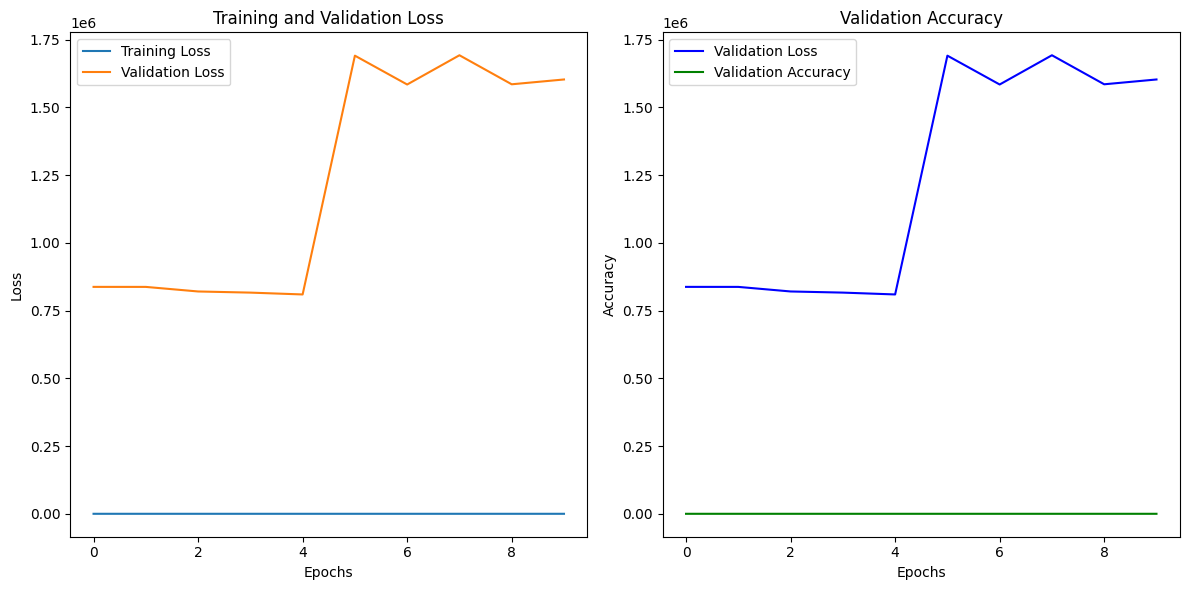

In [102]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### *Testing With MLP model*

1. **Preprocess data as done for training:**
   - Load Test images are loaded from the file '/kaggle/input/data-for-traintest/testing_data_task2.npy'.
   - Each test image (Sudoku puzzle) is encoded using the encode_inputs function.
   - A PyTorch TensorDataset is created from the encoded test data.
   - Uisng trained Model Predict the Digits.
5. **Post-processing and Saving Predictions:**
   - Predicted matrices are reshaped and processed to create submission format and are saved to a CSV file in the required submission format.

In [34]:
test_images = np.load('/kaggle/input/data-for-traintest/testing_data_task2.npy')

encode_test_data = [encode_inputs(matrix) for matrix in test_images]
encode_test_data = torch.cat(encode_test_data)

testing_dataset = TensorDataset(encode_test_data)
testing_dataloader = DataLoader(testing_dataset,batch_size=batch_size,shuffle=False)


In [35]:
for test_batch_index, ts_ in enumerate(testing_dataloader):
        sudoku_solver.eval()
        with torch.no_grad():
            test_pred = sudoku_solver(testing_dataset.tensors[0])

In [36]:
ids = []
values = []
predicted_matrix = torch.argmax(test_pred, dim=2)+1
for index, matrix in enumerate(predicted_matrix) : 
    reshaped_matrix = matrix.reshape(9,9)
    for row in range (0,9):
        for column in range(0,9):
            index_id = str(index) + "_" + str(row) + str(column)
            index_values = int(reshaped_matrix[row][column])
            ids.append(index_id)
            values.append(index_values)
    
    
results = pd.DataFrame({'id': ids , 'values' : values})
results.to_csv('final_predictions-task2-MLP.csv', index = False)

### *Approach 2 - (Using CNN)*

#### *Data Preprocessing*

1. **Checking Sudoku Validity and Fixing Missing Digits:**
   - The code iterates through each Sudoku puzzle in the training labels.
   - For each puzzle, it checks if it's a valid Sudoku using the `is_valid_sudoku` function.
   - If a Sudoku puzzle is not valid, it identifies the missing digits in the row where the error occurs.
   - If there's only one missing digit, it fills in the missing digit.
   - If there are two missing digits, it fills in the first missing digit, rechecks the validity, and then fills in the second missing digit if needed.

2. **Normalization:**
   - The function `apply_normalisation` normalizes each Sudoku puzzle in the training data.
   - It reshapes each puzzle into a 1x9x9 tensor and applies normalization by dividing each element by 9 and subtracting 0.5.
   - The normalized data is stored in a list named `normalised_data`.

3. **Processing Labels:**
   - The function `process_labels` processes the labels (Sudoku solutions) for training.
   - It flattens each Sudoku solution and subtracts 1 from each element to make the labels zero-based.
   - The processed labels are stored in a list named `modified_labels`.

4. **Conversion to Torch Tensors:**
   - The normalized data and processed labels are converted to PyTorch tensors.
   - `normalised_train_data` contains the normalized training data in float32 format.
   - `modified_labels` contains the processed labels in int64 format.

In [37]:
for index, sudoku in enumerate(train_labels):
    is_valid, sudoku_indices = is_valid_sudoku(sudoku.reshape(9, 9))
    
    if not is_valid:
        row, col = sudoku_indices
        row_values = train_labels[index][row].flatten()
        digits_missed = np.setdiff1d(np.arange(1, 10), row_values)
        
        if len(digits_missed) == 1:
            missing_digit = int(digits_missed[0])
            train_labels[index][row, col] = missing_digit
        
        elif len(digits_missed) == 2:
            missing_digit = digits_missed[0]
            train_labels[index][row, col] = missing_digit
            
            is_valid, sudoku_indices = is_valid_sudoku(sudoku.reshape(9, 9))
            row, col = sudoku_indices
            
            row_values = train_labels[index][row].flatten()
            digits_missed = np.setdiff1d(np.arange(1, 10), row_values)
            
            if len(digits_missed) == 1:
                missing_digit = int(digits_missed[0])
                train_labels[index][row, col] = missing_digit


In [40]:
normalised_data = []
def apply_normalisation(data_to_normalise):
    for data in data_to_normalise: 
        normalised_data.append(data.reshape(1,9,9) / 9 - 0.5)
    return normalised_data

In [41]:
modified_labels = []
def process_labels(labels):
    for label in labels : 
        modified_labels.append(label.reshape(81) - 1)
    return modified_labels

In [42]:
normalised_train_data = torch.tensor(apply_normalisation(train_data), dtype=torch.float32)
modified_labels = torch.tensor(process_labels(train_labels), dtype=torch.int64)

/tmp/ipykernel_26/499763236.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  normalised_train_data = torch.tensor(apply_normalisation(train_data), dtype=torch.float32)


#### *Create Datasets and Dataloaders*

1. **Data Preparation:**
   - The training dataset and evaluation dataset are created using the provided `train_data` and `modified_labels`. The data is split into training and evaluation sets based on the `train_split` ratio.
   - PyTorch `TensorDataset` objects are created for both datasets.
   - DataLoader objects are created to handle batch-wise data loading during training and evaluation.

In [44]:
train_split=0.7
total_elements = len(train_data)
training_size = int(train_split * total_elements)

train_dataset = TensorDataset(normalised_train_data[ : training_size], modified_labels[ : training_size])
eval_dataset = TensorDataset(normalised_train_data[training_size : ], modified_labels[training_size : ]) 

batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
eval_dataloader = DataLoader(eval_dataset,batch_size=batch_size,shuffle=True)

#### Define Model

1. **Input Layer:**
   - The input layer takes a batch of Sudoku puzzles represented as 9x9 grids.
   - The input shape is (batch_size, 1, 9, 9), where `batch_size` is the number of Sudoku puzzles in each batch here batch_size defined as 64.

2. **Convolutional Layers:**
   - A series of convolutional layers, which are capable of learning spatial patterns from the input grid are defined.
   - **`conv1`**: The first convolutional layer (`nn.Conv2d`) has 1 input channel and 64 output channels. It uses a 3x3 kernel with padding to maintain the spatial dimensions.
   - **`conv2`**: The second convolutional layer has 64 input channels and 128 output channels. It also uses a 3x3 kernel with padding.
   - **`conv3`**: The third convolutional layer has 128 input channels and 256 output channels. It employs the same 3x3 kernel with padding.
   - **`conv4`**: The fourth convolutional layer has 256 input channels and 256 output channels. It uses a 1x1 kernel to perform dimensionality reduction.

3. **Batch Normalization Layers:**
   - Batch normalization layers (`nn.BatchNorm2d`) are applied after each convolutional layer to normalize the activations and accelerate training.
   - **`bn1`**, **`bn2`**, **`bn3`**: Batch normalization layers are applied after `conv1`, `conv2`, and `conv3`, respectively.

4. **Activation Function:**
   - ReLU (Rectified Linear Unit) activation functions (`F.relu`) are applied after each batch normalization layer to introduce non-linearity into the model and enable it to learn complex patterns.

5. **Dropout Layers:**
   - Dropout layers (`nn.Dropout2d`) are used for regularization to prevent overfitting.
   - **`dropout`**: A dropout layer with a dropout probability of 0.3 is applied after `conv3`.
   - **`dropout`**: Another dropout layer with a dropout probability of 0.7 is applied before the fully connected layer.

6. **Fully Connected Layer:**
   - The output from the convolutional layers is flattened and fed into a fully connected layer (`nn.Linear`).
   - The fully connected layer (`fc1`) maps the flattened input to a vector with a size of 81x9, where each value represents the likelihood of each digit (1-9) appearing in each cell of the Sudoku puzzle.

7. **Output Layer:**
   - The output of the fully connected layer is reshaped to have a shape of (-1, 9), where `-1` indicates that the batch size is determined dynamically.
   - Each row of the output tensor represents the probabilities of the digits (1-9) appearing in a particular cell of the Sudoku puzzle.

In [45]:
import torch.nn as nn
import torch.nn.functional as F

class SudokuSolver(nn.Module):
    def __init__(self):
        super(SudokuSolver, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 256, kernel_size=1)
        self.dropout = nn.Dropout2d(p=0.3)
        
        self.fc1 = nn.Linear(256 * 9 * 9, 81 * 9)
        self.dropout = nn.Dropout2d(p=0.7) 

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x.view(-1, 9)

In [46]:
cnn_model = SudokuSolver()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#### Training Model

1. **Training Process**:
      - Iterates through each epoch.
      - **Training Phase**:
        - Computes training loss, backpropagates, and updates model parameters.
        - Calculates training accuracy and Losses.
      - **Validation Phase**:
        - Computes evaluation loss and accuracy on the evaluation dataset without backpropagation.

      - Returns Lists of training and evaluation losses and accuracies for analysis and plotting.

In [47]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

In [48]:
def train_model(cnn_model, train_dataloader, eval_dataloader, epochs):
    
    train_losses = []
    train_accuracies = []
    eval_losses = []
    eval_accuracies = []
    
    for epoch in range(epochs):
        cnn_model.train()
        train_loss = 0.0
        train_correct = 0
        total_trained = 0
        # Training Phase
        for unsolved_sudoku, labels in train_dataloader:
            unsolved_sudoku, labels = unsolved_sudoku.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn_model(unsolved_sudoku)
            loss = criterion(outputs, labels.view(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += calculate_accuracy(outputs, labels.view(-1)) * labels.size(0)
            total_trained += labels.size(0)

        avg_train_loss = train_loss / len(train_dataloader)
        train_accuracy = train_correct / total_trained
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        # Validation Phase
        cnn_model.eval()
        eval_loss = 0.0
        eval_correct = 0
        total_eval = 0

        with torch.no_grad():
            for eval_data, eval_labels in eval_dataloader:
                eval_data, eval_labels = eval_data.to(device), eval_labels.to(device)
                outputs = cnn_model(eval_data)
                eval_loss += criterion(outputs, eval_labels.view(-1)).item()

                eval_correct += calculate_accuracy(outputs, eval_labels.view(-1)) * eval_labels.size(0)
                total_eval += eval_labels.size(0)

        avg_eval_loss = eval_loss / len(eval_dataloader)
        eval_accuracy = eval_correct / total_eval
        
        
        eval_losses.append(avg_eval_loss)
        eval_accuracies.append(eval_accuracy)

        print(f'Epoch {epoch + 1}: '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {avg_eval_loss:.4f}, '
              f'Validation Accuracy: {eval_accuracy:.4f}')
    
    return train_losses,train_accuracies,eval_losses,eval_accuracies

In [49]:
train_losses,train_accuracies,eval_losses,eval_accuracies = train_model(cnn_model, train_dataloader, eval_dataloader, 25)

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Train Loss: 2.4334, Train Accuracy: 0.1537, Validation Loss: 1.9723, Validation Accuracy: 0.2242
Epoch 2: Train Loss: 1.9505, Train Accuracy: 0.2339, Validation Loss: 1.7449, Validation Accuracy: 0.3248
Epoch 3: Train Loss: 1.7964, Train Accuracy: 0.2989, Validation Loss: 1.5594, Validation Accuracy: 0.4436
Epoch 4: Train Loss: 1.6314, Train Accuracy: 0.3785, Validation Loss: 1.3315, Validation Accuracy: 0.5728
Epoch 5: Train Loss: 1.4706, Train Accuracy: 0.4542, Validation Loss: 1.1383, Validation Accuracy: 0.6585
Epoch 6: Train Loss: 1.3336, Train Accuracy: 0.5161, Validation Loss: 0.9866, Validation Accuracy: 0.7094
Epoch 7: Train Loss: 1.2176, Train Accuracy: 0.5644, Validation Loss: 0.8478, Validation Accuracy: 0.7450
Epoch 8: Train Loss: 1.1208, Train Accuracy: 0.6014, Validation Loss: 0.7520, Validation Accuracy: 0.7706
Epoch 9: Train Loss: 1.0446, Train Accuracy: 0.6280, Validation Loss: 0.6790, Validation Accuracy: 0.7864
Epoch 10: Train Loss: 0.9848, Train Accuracy: 

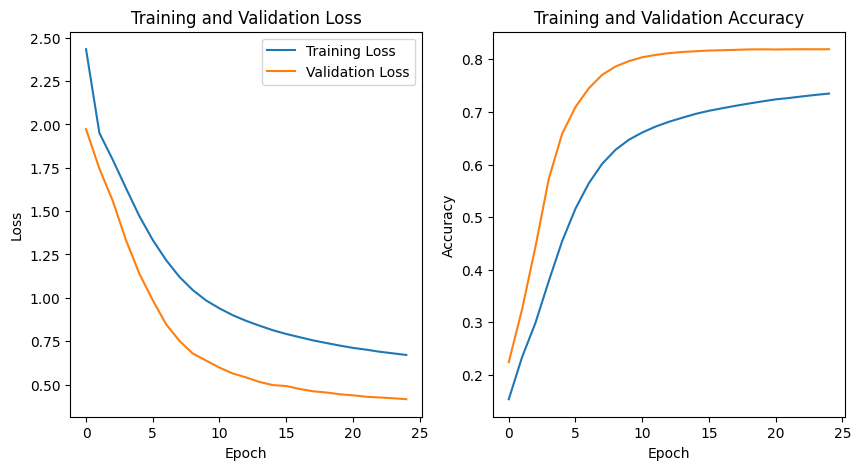

In [50]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(eval_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.show()

#### *Testing Sudoku*

1. **Preprocess data as done for training:**
   - Load Test images are loaded from the file '/kaggle/input/data-for-traintest/testing_data_task2.npy'.
   - Normalise the Data.
   - Uisng trained Model Predict the Digits.
5. **Post-processing and Saving Predictions:**
   - Predicted matrices are reshaped and processed to create submission format and are saved to a CSV file in the required submission format.

In [51]:
test_images = np.load('/kaggle/input/data-for-traintest/testing_data_task2.npy')

In [52]:

cnn_model.eval()
predictions = []

for data in test_images:
    normalized_data = torch.tensor(data, dtype=torch.float32).reshape(1, 1, 9, 9) / 9 - 0.5
    with torch.no_grad():
        output = cnn_model(normalized_data.to(device))
        digit_prediction = output.argmax(dim=1) + 1  # Convert predictions to 1-based indexing
        predictions.append(digit_prediction.cpu().numpy())
    


In [53]:
ids = []
values = []
for index, matrix in enumerate(predictions) : 
    reshaped_matrix = matrix.reshape(9,9)
    for row in range (0,9):
        for column in range(0,9):
            index_id = str(index) + "_" + str(row) + str(column)
            index_values = int(reshaped_matrix[row][column])
            ids.append(index_id)
            values.append(index_values)
    
    
results = pd.DataFrame({'id': ids , 'values' : values})
results.to_csv('final_predictions-task2-CNN.csv', index = False)
